### Notes for Modification

- Wake - Hands overlapping with face.
- Goose - Multiple variations of signs to represent the same thing.
- Nap - Hands overlapping with face/ Eyes close
- Give - Hands are closed.
- After - Hands overlapping
- Mouth - Hand closed, hand over mouth.

Commons Things:
- Closed hands
- Hands over face
- Overlapping landmarks

Solutions:
- Include eye landmarks.
- Backfill missing data with previous landmark data.
- Preserve relative distances between landmarks.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit 

from layers.PreprocessLayer import PreprocessLayer
from utils.Utils import print_shape_dtype, pd_read_s3_parquet, upload_file 

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
import boto3
import io
import wandb
import json

2023-04-06 03:51:09.982562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-06 03:51:10.614398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow versi

In [2]:
tf.get_logger().setLevel('INFO')

In [3]:
with open("./config.json") as fp:
    config = json.load(fp)

In [4]:
s3_client = boto3.client(
    "s3"
)

In [5]:
AWS_S3_BUCKET = "w251-asl-data"
TRAIN_CSV_FILE = "raw-data/train.csv"

In [6]:
train_file = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=TRAIN_CSV_FILE)

In [7]:
train = pd.read_csv(train_file.get("Body"))

N_SAMPLES = len(train)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 94477


In [8]:
# Get complete file path to file
def get_file_path(path):
    return f'{AWS_S3_BUCKET}/raw-data/{path}'

train['file_path'] = train['path'].apply(get_file_path)

In [9]:
# Add ordinally Encoded Sign (assign number to each sign name)
train['sign_ord'] = train['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [10]:
display(train.head(30))
display(train.info())

,path,participant_id,sequence_id,sign,file_path,sign_ord
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow,w251-asl-data/raw-data/train_landmark_files/26...,25
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait,w251-asl-data/raw-data/train_landmark_files/28...,232
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud,w251-asl-data/raw-data/train_landmark_files/16...,48
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird,w251-asl-data/raw-data/train_landmark_files/25...,23
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie,w251-asl-data/raw-data/train_landmark_files/62...,164
5,train_landmark_files/26734/1000241583.parquet,26734,1000241583,duck,w251-asl-data/raw-data/train_landmark_files/26...,67
6,train_landmark_files/26734/1000255522.parquet,26734,1000255522,minemy,w251-asl-data/raw-data/train_landmark_files/26...,143
7,train_landmark_files/32319/1000278229.parquet,32319,1000278229,lips,w251-asl-data/raw-data/train_landmark_files/32...,134
8,train_landmark_files/37055/100035691.parquet,37055,100035691,flower,w251-asl-data/raw-data/train_landmark_files/37...,86
9,train_landmark_files/29302/100039661.parquet,29302,100039661,time,w251-asl-data/raw-data/train_landmark_files/29...,220


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
 4   file_path       94477 non-null  object
 5   sign_ord        94477 non-null  int16 
dtypes: int16(1), int64(2), object(3)
memory usage: 3.8+ MB


None

In [11]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
ROWS_PER_FRAME = 543  # number of landmarks per frame
#w251-asl-data/raw-data/train_landmark_files/28656/3311214787.parquet

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd_read_s3_parquet(pq_path[14:], AWS_S3_BUCKET, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [ ]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""

USE_TYPES = ['left_hand', 'pose', 'right_hand']
START_IDX = 468
LIPS_IDXS0 = np.array([
        61, 185, 40, 39, 37, 0, 267, 269, 270, 409,
        291, 146, 91, 181, 84, 17, 314, 405, 321, 375,
        78, 191, 80, 81, 82, 13, 312, 311, 310, 415,
        95, 88, 178, 87, 14, 317, 402, 318, 324, 308,
    ])
# Landmark indices in original data
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)
POSE_IDXS0 = np.arange(502, 512)
LANDMARK_IDXS0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, POSE_IDXS0))
HAND_IDXS0 = np.concatenate((LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0), axis=0)
N_COLS = LANDMARK_IDXS0.size
# Landmark indices in processed data
LIPS_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LIPS_IDXS0)).squeeze()
LEFT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, LEFT_HAND_IDXS0)).squeeze()
RIGHT_HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, RIGHT_HAND_IDXS0)).squeeze()
HAND_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, HAND_IDXS0)).squeeze()
POSE_IDXS = np.argwhere(np.isin(LANDMARK_IDXS0, POSE_IDXS0)).squeeze()

print(f'# HAND_IDXS: {len(HAND_IDXS)}, N_COLS: {N_COLS}')

In [ ]:
LIPS_START = 0
LEFT_HAND_START = LIPS_IDXS.size
RIGHT_HAND_START = LEFT_HAND_START + LEFT_HAND_IDXS.size
POSE_START = RIGHT_HAND_START + RIGHT_HAND_IDXS.size

print(f'LIPS_START: {LIPS_START}, LEFT_HAND_START: {LEFT_HAND_START}, RIGHT_HAND_START: {RIGHT_HAND_START}, POSE_START: {POSE_START}')

In [ ]:
preprocess_layer = PreprocessLayer(config["N_ROWS"], config["N_DIMS"], HAND_IDXS0, LANDMARK_IDXS0, config["INPUT_SIZE"])

In [ ]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

In [ ]:
version = config["DATA_VERSION"]

# Get the full dataset
def get_x_y():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, INPUT_SIZE, N_COLS, N_DIMS], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, INPUT_SIZE], -1, dtype=np.float32)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data
    
    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
    
    # Put to S3
    upload_file("./X.npy", AWS_S3_BUCKET, f'processed-data/v{version}/X.npy')
    upload_file("./y.npy", AWS_S3_BUCKET, f'processed-data/v{version}/y.npy')
    upload_file("./NON_EMPTY_FRAME_IDXS.npy", AWS_S3_BUCKET, f'processed-data/v{version}/NON_EMPTY_FRAME_IDXS.npy')
    
    return X, y, NON_EMPTY_FRAME_IDXS

In [ ]:
if PREPROCESS_DATA:
    X, y, NON_EMPTY_FRAME_IDXS = get_x_y()
else:
    X = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=f'processed-data/v{version}/X.npy')
    X = np.load(io.BytesIO(X['Body'].read()))
    
    y = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=f'processed-data/v{version}/y.npy')
    y = np.load(io.BytesIO(y['Body'].read()))
    
    NON_EMPTY_FRAME_IDXS = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=f'processed-data/v{version}/NON_EMPTY_FRAME_IDXS.npy')
    NON_EMPTY_FRAME_IDXS = np.load(io.BytesIO(NON_EMPTY_FRAME_IDXS['Body'].read()))
    
print_shape_dtype([X, y, NON_EMPTY_FRAME_IDXS], ['X', 'y', 'NON_EMPTY_FRAME_IDXS'])
print(f'# NaN Values X: {np.isnan(X).sum()}')

In [ ]:
display(pd.Series(y).value_counts().to_frame('Class Count').iloc[[0,1,2,3,4, -5,-4,-3,-2,-1]])

In [ ]:
X = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=f'processed-data/v{version}/X.npy')
X = np.load(io.BytesIO(X['Body'].read()))

y = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=f'processed-data/v{version}/y.npy')
y = np.load(io.BytesIO(y['Body'].read()))

NON_EMPTY_FRAME_IDXS = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key=f'processed-data/v{version}/NON_EMPTY_FRAME_IDXS.npy')
NON_EMPTY_FRAME_IDXS = np.load(io.BytesIO(NON_EMPTY_FRAME_IDXS['Body'].read()))

In [ ]:
pp = PreprocessLayerMod(config["N_ROWS"], config["N_DIMS"], HAND_IDXS0, LANDMARK_IDXS0, config["INPUT_SIZE"])

In [12]:
# Execution when there are less frames than specificed input size. 
data0 = load_relevant_data_subset("w251-asl-data/raw-data/train_landmark_files/28656/1000106739.parquet")
N_FRAMES0 = tf.shape(data0)[0] # 11
gather = tf.gather(data0, HAND_IDXS0, axis=1) # Returns all frames with hand landmark data
frames_hands_nansum = tf.experimental.numpy.nanmean(gather, axis=[1,2]) # Get mean across X,Y sum them together
non_empty_frames_idxs = tf.where(frames_hands_nansum > 0) 
non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1) # Get indicies where there are no NAN
data = tf.gather(data0, non_empty_frames_idxs, axis=0) # Put frames that have non-empty indicies into single tensor
non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) # Cast
N_FRAMES = tf.shape(data)[0] # Number of frames in the video with non-empty hands
data = tf.gather(data, LANDMARK_IDXS0, axis=1) # Filters out landmarks that have not been selected
# Pads to the right of non_empty_frames_idxs with -1's
non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, config["INPUT_SIZE"]-N_FRAMES]], constant_values=-1)
data = tf.pad(data, [[0, config["INPUT_SIZE"]-N_FRAMES], [0,0], [0,0]], constant_values=0) # Fill all the -1's with zero values.
data = tf.where(tf.math.is_nan(data), 0.0, data) # Fill all NANs with 0.

2023-04-06 03:51:35.565028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 03:51:35.586619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-06 03:51:35.588643: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

NameError: name 'HAND_IDXS0' is not defined

In [ ]:
### Modified testing

data = tf.gather(data0, LANDMARK_IDXS0, axis=1)

In [ ]:
data.shape

In [ ]:
class PreprocessLayerMod(tf.keras.layers.Layer):
    def __init__(self, N_ROWS, N_DIMS, HAND_IDXS0, LANDMARK_IDXS0, INPUT_SIZE):
        super(PreprocessLayerMod, self).__init__()
        self.N_ROWS = N_ROWS
        self.N_DIMS = N_DIMS
        self.HAND_IDXS0 = HAND_IDXS0
        self.LANDMARK_IDXS0 = LANDMARK_IDXS0
        self.INPUT_SIZE = INPUT_SIZE
        self.N_COLS = LANDMARK_IDXS0.size
        
    def pad_edge(self, t, repeats, side):
        if side == 'LEFT':
            return tf.concat((tf.repeat(t[:1], repeats=repeats, axis=0), t), axis=0)
        elif side == 'RIGHT':
            return tf.concat((t, tf.repeat(t[-1:], repeats=repeats, axis=0)), axis=0)
    
    @tf.function(
        input_signature=(tf.TensorSpec(shape=[None, 543, 2], dtype=tf.float32),),
    )
    def call(self, data0):
        # Number of Frames in Video
        N_FRAMES0 = tf.shape(data0)[0]
        
        # Filter Out Frames With Empty Hand Data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data0, self.HAND_IDXS0, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data0, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 

        # Number of Frames in Filtered Video
        N_FRAMES = tf.shape(data)[0]
        
        # Gather Relevant Landmark Columns
        data = tf.gather(data, self.LANDMARK_IDXS0, axis=1)
        
        # Video fits in self.INPUT_SIZE
        if N_FRAMES < self.INPUT_SIZE:
            # Pad With -1 to indicate padding
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, self.INPUT_SIZE-N_FRAMES]], constant_values=-1)
            # Pad Data With Zeros
            data = tf.pad(data, [[0, self.INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Repeat
            if N_FRAMES < self.INPUT_SIZE**2:
                repeats = tf.math.floordiv(self.INPUT_SIZE * self.INPUT_SIZE, N_FRAMES0)
                data = tf.repeat(data, repeats=repeats, axis=0)
                non_empty_frames_idxs = tf.repeat(non_empty_frames_idxs, repeats=repeats, axis=0)

            # Pad To Multiple Of Input Size
            pool_size = tf.math.floordiv(len(data), self.INPUT_SIZE)
            if tf.math.mod(len(data), self.INPUT_SIZE) > 0:
                pool_size += 1

            if pool_size == 1:
                pad_size = (pool_size * self.INPUT_SIZE) - len(data)
            else:
                pad_size = (pool_size * self.INPUT_SIZE) % len(data)

            # Pad Start/End with Start/End value
            pad_left = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(self.INPUT_SIZE, 2)
            pad_right = tf.math.floordiv(pad_size, 2) + tf.math.floordiv(self.INPUT_SIZE, 2)
            if tf.math.mod(pad_size, 2) > 0:
                pad_right += 1

            # Pad By Concatenating Left/Right Edge Values
            data = self.pad_edge(data, pad_left, 'LEFT')
            data = self.pad_edge(data, pad_right, 'RIGHT')

            # Pad Non Empty Frame Indices
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_left, 'LEFT')
            non_empty_frames_idxs = self.pad_edge(non_empty_frames_idxs, pad_right, 'RIGHT')

            # Reshape to Mean Pool
            data = tf.reshape(data, [self.INPUT_SIZE, -1, self.N_COLS, self.N_DIMS])
            non_empty_frames_idxs = tf.reshape(non_empty_frames_idxs, [self.INPUT_SIZE, -1])

            # Mean Pool
            data = tf.experimental.numpy.nanmean(data, axis=1)
            non_empty_frames_idxs = tf.experimental.numpy.nanmean(non_empty_frames_idxs, axis=1)

            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            
            return data, non_empty_frames_idxs

In [22]:
LIPS_IDXS0 = [0, 11, 12, 13, 14, 15, 17, 37, 38, 39, 40, 41, 42, 61, 62, 72, 73, 
        74, 76, 77, 78, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 95, 96, 146, 
        178, 179, 180, 181, 183, 184, 185, 191, 267, 268, 269, 270, 271, 272, 
        291, 292, 302, 303, 304, 306, 307, 308, 310, 311, 312, 314, 316, 317, 
        318, 319, 320, 321, 324, 325, 375, 402, 403, 404, 405, 407, 408, 409, 415]

EYES_IDXS0 = [  6,   7,  22,  23,  24,  25,  26,  30,  31,  33,  56, 110, 112,
       113, 122, 128, 130, 133, 144, 145, 153, 154, 155, 157, 158, 159,
       160, 161, 163, 168, 173, 188, 189, 190, 193, 196, 197, 232, 233,
       243, 244, 245, 246, 247, 249, 252, 253, 254, 255, 256, 259, 260,
       263, 286, 339, 341, 351, 357, 359, 362, 373, 374, 380, 381, 382,
       384, 385, 386, 387, 388, 390, 398, 412, 413, 414, 417, 419, 453,
       463, 464, 465, 466, 467]

# POSE_IDXS0 = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
#        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]

POSE_IDXS0 = np.arange(502, 512)
LEFT_HAND_IDXS0 = np.arange(468,489)
RIGHT_HAND_IDXS0 = np.arange(522,543)

LANDMARK_IDXS0 = np.concatenate((LIPS_IDXS0, LEFT_HAND_IDXS0, RIGHT_HAND_IDXS0, EYES_IDXS0, POSE_IDXS0))

In [45]:
len(LANDMARK_IDXS0)

212

In [20]:
data[0][POSE_IDXS0]

array([[ 5.58298886e-01,  4.63002384e-01],
       [ 6.02611661e-01,  4.18690920e-01],
       [ 6.28177881e-01,  4.20569062e-01],
       [ 6.49016082e-01,  4.23131078e-01],
       [ 5.10920703e-01,  4.18736964e-01],
       [ 4.81898695e-01,  4.21183467e-01],
       [ 4.58743930e-01,  4.24462974e-01],
       [ 6.87426031e-01,  4.48747903e-01],
       [ 4.30427939e-01,  4.49997783e-01],
       [ 6.03306472e-01,  5.25382757e-01],
       [ 5.01094818e-01,  5.28297424e-01],
       [ 8.26361716e-01,  6.71795845e-01],
       [ 3.03589582e-01,  6.46503508e-01],
       [ 9.90334034e-01,  9.74739611e-01],
       [-9.86907165e-04,  7.66859233e-01],
       [ 9.43818748e-01,  1.17694294e+00],
       [ 1.03133924e-01,  5.88010728e-01],
       [ 9.47321951e-01,  1.26920629e+00],
       [ 9.86627042e-02,  5.58533251e-01],
       [ 9.03593540e-01,  1.23730671e+00],
       [ 1.34045810e-01,  5.38975537e-01],
       [ 8.87158155e-01,  1.20615578e+00],
       [ 1.47983044e-01,  5.58624804e-01],
       [ 7.

In [30]:
data = pd_read_s3_parquet("raw-data/train_landmark_files/28656/1000106739.parquet", AWS_S3_BUCKET,)
data[data['type']=='pose']

,frame,row_id,type,landmark_index,x,y,z
489,29,29-pose-0,pose,0,0.558299,0.463002,-1.549376
490,29,29-pose-1,pose,1,0.602612,0.418691,-1.467385
491,29,29-pose-2,pose,2,0.628178,0.420569,-1.468376
492,29,29-pose-3,pose,3,0.649016,0.423131,-1.469032
493,29,29-pose-4,pose,4,0.510921,0.418737,-1.462460
...,...,...,...,...,...,...,...
5947,39,39-pose-28,pose,28,0.280855,2.031735,0.948414
5948,39,39-pose-29,pose,29,0.622959,2.127774,0.340365
5949,39,39-pose-30,pose,30,0.286632,2.094783,0.983788
5950,39,39-pose-31,pose,31,0.515856,2.178496,-0.413913


In [ ]:
data['index'] = data['type'] + data['landmark_index'].astype(str)
data['index_ord'] = data['index'].astype('category').cat.codes
# data[data['frame']==29].sort_values('index_ord').head(50)

data[(data['frame']==29) & (data['index_ord']>=502) & (data['index_ord']<=512)]

<Axes: xlabel='x', ylabel='y'>

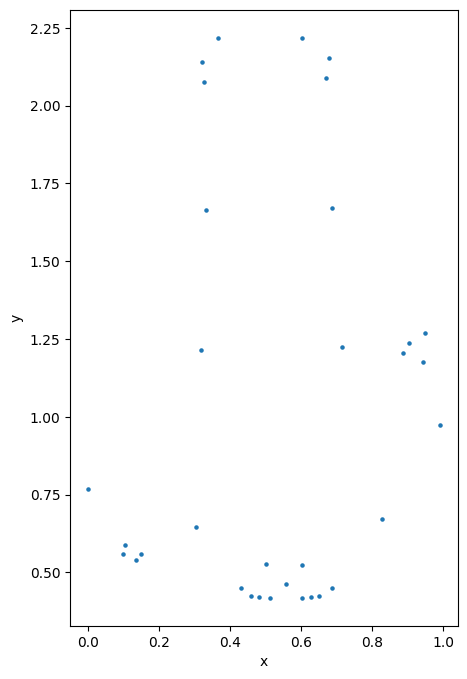

In [31]:

data[(data['frame']==29) & (data['type']=='pose')][['x','y']].plot.scatter(x='x',y='y', marker='.', figsize=(5,8))

<Axes: xlabel='x', ylabel='y'>

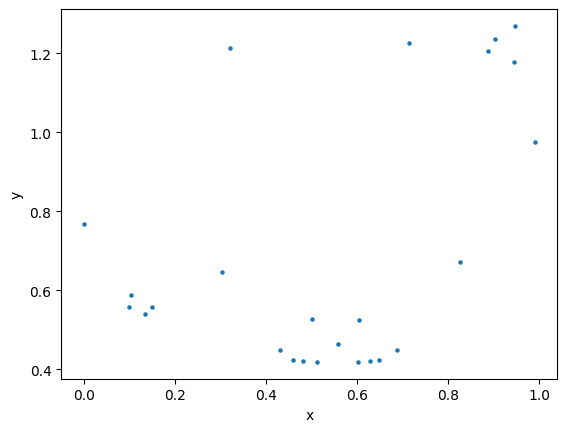

In [33]:
data[(data['frame']==29) & (data['type']=='pose')  & (data['y']<1.4)
    ].plot.scatter(x='x',y='y', marker='.')
# data

In [ ]:
data[(data['frame']==29) & (data['type']=='face') & (data['landmark_index'].isin(EYES))].plot.scatter(x='x',y='y', marker='.')

In [ ]:
POSE

In [ ]:
# LIPS = list(set(np.concatenate((data[(data['frame']==29) & (data['type']=='face') & (data['x']>0.52)  & (data['x']<.63) & (data['y']>0.5)  & (data['y']<.545)
#     ].landmark_index.unique(), LIPS_IDXS0))))
LIPS = [0, 11, 12, 13, 14, 15, 17, 37, 38, 39, 40, 41, 42, 61, 62, 72, 73, 
        74, 76, 77, 78, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 95, 96, 146, 
        178, 179, 180, 181, 183, 184, 185, 191, 267, 268, 269, 270, 271, 272, 
        291, 292, 302, 303, 304, 306, 307, 308, 310, 311, 312, 314, 316, 317, 
        318, 319, 320, 321, 324, 325, 375, 402, 403, 404, 405, 407, 408, 409, 415]

EYES = [  6,   7,  22,  23,  24,  25,  26,  30,  31,  33,  56, 110, 112,
       113, 122, 128, 130, 133, 144, 145, 153, 154, 155, 157, 158, 159,
       160, 161, 163, 168, 173, 188, 189, 190, 193, 196, 197, 232, 233,
       243, 244, 245, 246, 247, 249, 252, 253, 254, 255, 256, 259, 260,
       263, 286, 339, 341, 351, 357, 359, 362, 373, 374, 380, 381, 382,
       384, 385, 386, 387, 388, 390, 398, 412, 413, 414, 417, 419, 453,
       463, 464, 465, 466, 467]


POSE = [ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]

# EYES = data[(data['frame']==29) & (data['type']=='face') & (data['x']>0.46)  & (data['x']<.683) & (data['y']>0.4)  & (data['y']<.43)].landmark_index.unique()
# POSE = data[(data['frame']==29) & (data['type']=='pose')].landmark_index.unique()

In [34]:
POSE = data[(data['frame']==29) & (data['type']=='pose')  & (data['y']<1.4)
    ].landmark_index.unique()

In [35]:
POSE

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24], dtype=int16)